INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units 
in the first densely-connected
layer is 128, the optimal number of units 
in the second densely-connected
layer is 512, the optimal learning rate for 
the optimizer
is 0.1, and the optimal l2 parameter for normalization is 1e-06.

Epoch 1/1000
188/188 [==============================] - 4s 11ms/step - loss: 0.5400 - f1_m: 2.0752 - val_loss: 0.2831 - val_f1_m: 1.3143
Epoch 2/1000
188/188 [==============================] - 2s 11ms/step - loss: 0.2639 - f1_m: 1.2650 - val_loss: 0.2200 - val_f1_m: 1.2218
Epoch 3/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.2111 - f1_m: 1.1957 - val_loss: 0.1877 - val_f1_m: 1.1699
Epoch 4/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.1763 - f1_m: 1.152

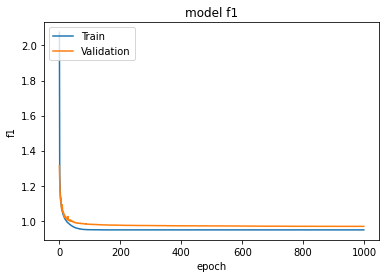

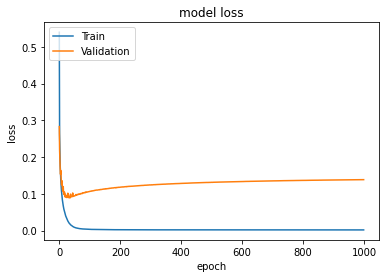

In [5]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).
batch_size = 256


 # Prepare MNIST data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.




def model_builder(hp):


  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape = (num_features, )))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value from 64, 128
  hp_units_1 = hp.Choice('units_1', values=[64, 128])

  # Tune the number of units in the second Dense layer
  # Choose an optimal value from 256, 512
  hp_units_2 = hp.Choice('units_2', values=[256, 512])

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.1, 0.01, or 0.001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

  # Tune parameter l2 for L2-norm
  # Choose an optimal value from 0.1, 0.001, or 0.000001
  hp_l2 = hp.Choice('l2', values=[1e-1, 1e-3, 1e-6])

  
  model.add(keras.layers.Dense(units = hp_units_1, activation = 'relu',kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.L2(hp_l2)))
  model.add(keras.layers.Dense(units = hp_units_2, activation = 'relu', kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.L2(hp_l2)))
  model.add(keras.layers.Dense(10, activation = 'softmax', kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.L2(hp_l2)))


  model.compile(optimizer = keras.optimizers.SGD(learning_rate = hp_learning_rate), loss = keras.losses.SparseCategoricalCrossentropy(), metrics=[f1_m])

  return model


tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=2)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units 
in the first densely-connected
layer is {best_hps.get('units_1')}, the optimal number of units 
in the second densely-connected
layer is {best_hps.get('units_2')}, the optimal learning rate for 
the optimizer
is {best_hps.get('learning_rate')}, and the optimal l2 parameter for normalization is {best_hps.get('l2')}.
""")



#Build the model with the optimal hyperparameters and train it on the data for 1000 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train, batch_size=256, epochs=1000, validation_split=0.2)

yhat_probs = model.predict(x_test) #predict probabilities for test set
yhat_classes = np.argmax(yhat_probs, axis=1) #take indice of max prob for each sample (this indice is the number guessed)



#Confusion matrix and metrics
confusion = confusion_matrix(y_test, yhat_classes)
print(f"Confusion Matrix:{confusion}")

accuracy = accuracy_score(y_test, yhat_classes)
print(f"Accuracy Score: {accuracy}")

                          
precision = precision_score(y_test, yhat_classes,average='micro')
print('Precision: %f' % precision)

recall = recall_score(y_test, yhat_classes,average='micro')
print('Recall: %f' % recall) 



# summarize history for accuracy
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
